In [40]:
import os
import copy
import cantera as ct
import numpy as np
import pandas as pd
import concurrent.futures
import rmgpy.chemkin
import pickle


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load base data

base_rmg7 = np.array([0.04908328, 0.04854439, 0.04814446, 0.04868176, 0.075588  ,
       0.07737167, 0.14791668, 0.14857535, 0.1085917 , 0.0952434 ,
       0.06520823, 0.05563237, 0.03535775, 0.02462961, 0.02334903,
       0.01398333])  # 24 hour RMG run - 110 species

aramco7 = np.array([0.03945921, 0.03874611, 0.02817182, 0.02812066, 0.03236667,
       0.03278732, 0.06009581, 0.06085926, 0.06020536, 0.05459522,
       0.03965133, 0.03435827, 0.02245863, 0.01580939, 0.01499945,
       0.00896072])
experiment7 = np.array([0.0865 , 0.0739 , 0.0313 , 0.033  , 0.0309 , 0.03   , 0.056  ,
       0.0566 , 0.0679 , 0.0664 , 0.0652 , 0.0671 , 0.047  , 0.0279 ,
       0.02805, 0.012  ])


In [3]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)


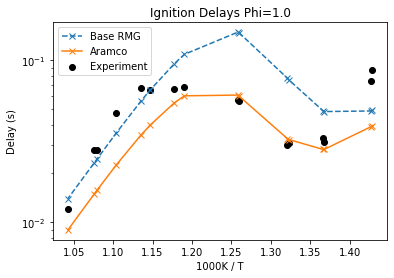

In [4]:
# plot the ignition delay
plt.plot(1000.0 / T7, base_rmg7, marker='x', linestyle='dashed')
plt.plot(1000.0 / T7, aramco7, marker='x')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['Base RMG', 'Aramco', 'Experiment'])
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)

In [5]:
# get the mapping from cantera base back to RMG
# load the sensitive parameters
chemkin = '/home/moon/autoscience/reaction_calculator/delay_uncertainty/base_model/chem_annotated.inp'
working_dir = os.path.dirname(chemkin)
transport = os.path.join(working_dir, 'tran.dat')
species_dict = os.path.join(working_dir, 'species_dictionary.txt')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin, dictionary_path=species_dict, transport_path=transport, use_chemkin_names=True)

base_gas = ct.Solution(os.path.join(working_dir, 'base.cti'))

# Check that species order is preserved
for i in range(len(species_list)):
    assert str(species_list[i]) == base_gas.species_names[i]

In [6]:
def same_reaction(rmg_rxn, ct_rxn):
    rmg_r = set([str(x) for x in rmg_rxn.reactants])
    rmg_p = set([str(x) for x in rmg_rxn.products])
    
    ct_r = set(ct_rxn.reactants.keys())
    ct_p = set(ct_rxn.products.keys())
    return rmg_r == ct_r and rmg_p == ct_p

In [7]:
# this takes a really long time to run, so try loading the file first
if os.path.exists('ct2rmg_rxn.pickle'):
    with open('ct2rmg_rxn.pickle', 'rb') as handle:
        ct2rmg_rxn = pickle.load(handle)
else:
    ct2rmg_rxn = {}
    for i in range(len(base_gas.reactions())):
        try:
            if same_reaction(reaction_list[i], base_gas.reactions()[i]):
                ct2rmg_rxn[i] = i
                continue
        except IndexError:
            pass

        for j in range(len(reaction_list)):
            if same_reaction(reaction_list[j], base_gas.reactions()[i]):
                ct2rmg_rxn[i] = j
                break
        else:
            print('no match found!', base_gas.reactions()[i])
    # save the result
    with open('ct2rmg_rxn.pickle', 'wb') as handle:
        pickle.dump(ct2rmg_rxn, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
len(ct2rmg_rxn)

1850

In [9]:
# load the parameter uncertainties
thermo_uncertainty_file = '/home/moon/autoscience/autoscience/paper/models/base_rmg/thermo_uncertainty.npy'
kinetic_uncertainty_file = '/home/moon/autoscience/autoscience/paper/models/base_rmg/kinetic_uncertainty.npy'


thermo_uncertainties_rmg = np.load(thermo_uncertainty_file)
kinetic_uncertainties_rmg = np.load(kinetic_uncertainty_file)


thermo_uncertainties_ct = thermo_uncertainties_rmg  # there's a one to one correspondence
kinetic_uncertainties_ct = np.zeros(len(base_gas.reactions()))
# need to go from cantera reaction to rmg reaction
for i in range(len(kinetic_uncertainties_ct)):
    rmg_index = ct2rmg_rxn[i]
    kinetic_uncertainties_ct[i] = kinetic_uncertainties_rmg[rmg_index]


In [202]:
# load the parameter delays
table_index = 7
# condition_index = 7

# species_delays = base_rmg7[table_index] + (np.random.random((len(base_gas.species()), len(concentrations))) / 1e4)
# reaction_delays = base_rmg7[table_index] + (np.random.random((len(base_gas.reactions()), len(concentrations))) / 1e5)

species_delays = np.load(os.path.join(working_dir, f'species_delays_{table_index:04}.npy'))
reaction_delays = np.load(os.path.join(working_dir, f'reaction_delays_{table_index:04}.npy'))


In [206]:
for i in range(reaction_delays.shape[0]):
    if reaction_delays[i, 0] == 0:
        rmg_index = ct2rmg_rxn[i]
        try:
            family = reaction_list[rmg_index].family
        except AttributeError:
            continue
        try:
            a = reaction_list[rmg_index].kinetics.A.value
        except AttributeError:
            continue
        print(f'Missing answer for RMG reaction {rmg_index} and not PDEP')
        print(reaction_list[rmg_index].family)
        

Missing answer for RMG reaction 1073 and not PDEP
Disproportionation
Missing answer for RMG reaction 1075 and not PDEP
CurranPentane
Missing answer for RMG reaction 1076 and not PDEP
CurranPentane
Missing answer for RMG reaction 1077 and not PDEP
CurranPentane
Missing answer for RMG reaction 1078 and not PDEP
CurranPentane
Missing answer for RMG reaction 1079 and not PDEP
CurranPentane
Missing answer for RMG reaction 1080 and not PDEP
CurranPentane
Missing answer for RMG reaction 1081 and not PDEP
CurranPentane
Missing answer for RMG reaction 1082 and not PDEP
CurranPentane
Missing answer for RMG reaction 1083 and not PDEP
CurranPentane
Missing answer for RMG reaction 1084 and not PDEP
CurranPentane
Missing answer for RMG reaction 1085 and not PDEP
CurranPentane
Missing answer for RMG reaction 1086 and not PDEP
CurranPentane
Missing answer for RMG reaction 1087 and not PDEP
CurranPentane
Missing answer for RMG reaction 1088 and not PDEP
CurranPentane
Missing answer for RMG reaction 108

In [207]:
# TODO remove this to get the full uncertainty estimate
# set zeros to base_delay
for i in range(reaction_delays.shape[0]):
    if reaction_delays[i, 0] == 0:
        reaction_delays[i, :] = base_rmg7

In [201]:
np.where(reaction_delays == 0)

(array([  14,   14,   14, ..., 1849, 1849, 1849]),
 array([ 0,  1,  2, ..., 13, 14, 15]))

In [54]:
base_rmg7[7]

0.14857535

In [208]:
base_delays_sp_mat = np.repeat(np.matrix(base_rmg7), species_delays.shape[0], axis=0)
d_ln_Tau_sp_mat = np.log(species_delays) - np.log(base_delays_sp_mat)
d_Tau_sp_mat = species_delays - base_delays_sp_mat

base_delays_rxn_mat = np.repeat(np.matrix(base_rmg7), reaction_delays.shape[0], axis=0)
# d_ln_Tau_rxn_mat = np.log(reaction_delays) - np.log(base_delays_rxn_mat)
d_Tau_rxn_mat = reaction_delays - base_delays_rxn_mat

In [176]:
# set the unperturbed ones to zero:
for i in range(0, len(base_gas.reactions())):
    rmg_index = ct2rmg_rxn[i]
    
    try:
        a = reaction_list[rmg_index].kinetics.A.value
    except AttributeError:
        d_Tau_rxn_mat[i, :] = np.zeros(reaction_delays.shape[1])
    


In [177]:
np.min(np.abs(d_Tau_rxn_mat))

0.0

In [113]:
# get the dG values
def perturb_species(species, delta):
    # takes in an RMG species object
    # change the enthalpy offset
    for poly in species.thermo.polynomials:
        new_coeffs = poly.coeffs
        new_coeffs[5] *= (1.0 + delta)
        poly.coeffs = new_coeffs

def perturb_reaction(rxn, delta):
    # takes in an RMG reaction object
    # delta is the ln(k) amount to perturb the A factor
    # delta is a multiplicative factor- units don't matter, yay!
    # does not deepycopy because there's some issues with rmgpy.reactions copying
    rxn.kinetics.A.value *= np.exp(delta)

In [114]:
# compute the thermo sensitivities
dG_kcal_mol = np.zeros(species_delays.shape)
delta = 0.1
for i in range(0, len(species_list)):
    perturbed_species = copy.deepcopy(species_list[i])
    perturb_species(perturbed_species, delta)
    for j in range(0, len(T7)):
        T = T7[j]
        dG_kcal_mol[i, j] = (perturbed_species.get_free_energy(T) - species_list[i].get_free_energy(T)) * 0.00239006  # to convert J/mol to kcal/mol


In [209]:
# compute the kinetic perturbations
dlnk_rmg = np.zeros(reaction_delays.shape)
delta = 0.1
P = 10.0 * 101325  # 10 atm
PDEP_UNCERTAINTY = 0.5
for i in range(0, len(reaction_list)):
    if type(reaction_list[i]) in [rmgpy.rmg.pdep.PDepReaction]:
        continue
    perturbed_reaction = copy.deepcopy(reaction_list[i])
    try:
        perturb_reaction(perturbed_reaction, delta)
    except AttributeError:
        continue
    for j in range(0, len(T7)):
        T = T7[j]
        dlnk_rmg[i, j] = np.log(perturbed_reaction.get_rate_coefficient(T, P)) - np.log(reaction_list[i].get_rate_coefficient(T, P))
        


In [210]:
# convert from rmg matrix to cantera matrix
dlnk_ct = np.zeros((len(base_gas.reactions()), reaction_delays.shape[1]))
for i in range(len(base_gas.reactions())):
    rmg_index = ct2rmg_rxn[i]
    dlnk_ct[i, :] = dlnk_rmg[rmg_index, :]


In [220]:
# compute average dlnk
nonzero_idx = np.where(dlnk_ct != 0)[0] 
len(np.where(dlnk_ct != 0)[0])

average_dlnk = np.average(dlnk_ct[nonzero_idx])

print(average_dlnk)
# total
# for i in range(0, dlnk_ct.shape[0]):
    

0.10000000000000034


In [227]:
# thermo_sensitivity_squared = np.float_power(d_ln_Tau_mat, 2.0)
thermo_sensitivity_squared = np.float_power(d_Tau_sp_mat, 2.0)
dG_squared = np.float_power(dG_kcal_mol, 2.0)
species_uncertainty_squared_mat = np.float_power(np.repeat(np.matrix(thermo_uncertainties_rmg).transpose(), len(concentrations), axis=1), 2.0)

total_thermo_uncertainty = np.sum(np.multiply(np.divide(thermo_sensitivity_squared, dG_squared), species_uncertainty_squared_mat), axis=0)


# kinetic_sensitivity_squared = np.float_power(d_ln_Tau_rxn_mat, 2.0)
kinetic_sensitivity_squared = np.float_power(d_Tau_rxn_mat, 2.0)
# set zero dlnk values to 0.1
dlnk_ct[np.where(dlnk_ct == 0)[0]] = 0.1
dlnk_squared = np.float_power(dlnk_ct, 2.0)

# change the zeros to the average nonzero value

reaction_uncertainty_squared_mat = np.float_power(np.repeat(np.matrix(kinetic_uncertainties_ct).transpose(), len(concentrations), axis=1), 2.0)
# reaction_uncertainty_squared_mat = np.repeat(np.matrix(kinetic_uncertainties_ct).transpose(), len(concentrations), axis=1)  # it's already been squared
partial_kinetic_uncertainties = np.multiply(np.divide(kinetic_sensitivity_squared, dlnk_squared), reaction_uncertainty_squared_mat)
total_kinetic_uncertainty = np.sum(np.multiply(np.divide(kinetic_sensitivity_squared, dlnk_squared), reaction_uncertainty_squared_mat), axis=0)


In [222]:
total_thermo_uncertainty

matrix([[1.00249753e-03, 9.53830813e-04, 4.31816073e-04, 4.34884371e-04,
         6.39478665e-04, 6.46229826e-04, 3.68343280e-04, 3.53612158e-04,
         3.09952570e-05, 1.81248565e-05, 4.70229365e-06, 2.83676000e-06,
         7.83567359e-07, 3.32725608e-07, 2.97542925e-07, 1.29553454e-07]])

In [223]:
total_kinetic_uncertainty

matrix([[0.00279928, 0.00284132, 0.00877253, 0.0092753 , 0.03954318,
         0.04189952, 0.06726155, 0.06475841, 0.00584422, 0.00361991,
         0.00130814, 0.00095082, 0.00044866, 0.00026242, 0.00024272,
         0.00011467]])

In [229]:
lower_bound = base_rmg7 - total_thermo_uncertainty - total_kinetic_uncertainty
upper_bound = base_rmg7 + total_thermo_uncertainty + total_kinetic_uncertainty


In [230]:
total_thermo_uncertainty

matrix([[1.00249753e-03, 9.53830813e-04, 4.31816073e-04, 4.34884371e-04,
         6.39478665e-04, 6.46229826e-04, 3.68343280e-04, 3.53612158e-04,
         3.09952570e-05, 1.81248565e-05, 4.70229365e-06, 2.83676000e-06,
         7.83567359e-07, 3.32725608e-07, 2.97542925e-07, 1.29553454e-07]])

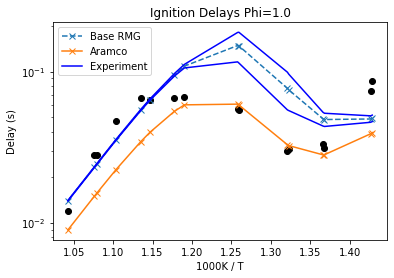

In [231]:
# put error bars on the plot

# plot the ignition delay
plt.plot(1000.0 / T7, base_rmg7, marker='x', linestyle='dashed')
plt.plot(1000.0 / T7, aramco7, marker='x')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')

plt.plot(1000.0 / T7, lower_bound.transpose(), color='blue')
plt.plot(1000.0 / T7, upper_bound.transpose(), color='blue')

ax = plt.gca()
ax.set_yscale('log')
plt.legend(['Base RMG', 'Aramco', 'Experiment'])
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)



In [16]:
len(concentrations)

16